# RMS to interval velocity problem 

Forward mapping 

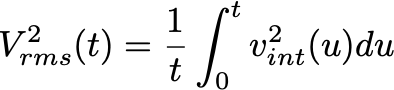

- $v_int$: interval velocity
- $V_{rms}$: rms velocity 

inverse mapping 

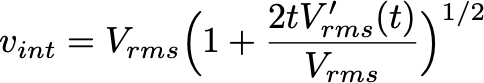

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## define interval velocity 

$$v_{int} = v_0 + a \sin(2\pi f t)$$

In [2]:
def interval_velocity_analytic(time, velocity0, amplitude, frequency): 
    """
    define our interval velocity as a harmonic function with amplitude (a), frequency (f), and base-value v0
    """
    return velocity0 + amplitude *np.sin(2*np.pi*frequency*time)

In [3]:
a = 50
v0 = 2000 
f = 2

In [4]:
n_times = 200 
max_time = 2
time = np.linspace(0, 2, n_times)

In [5]:
# vint = interval_velocity_analytic(time, v0, a, f)
vint = interval_velocity_analytic(time=time, velocity0=v0, amplitude=a, frequency=f)

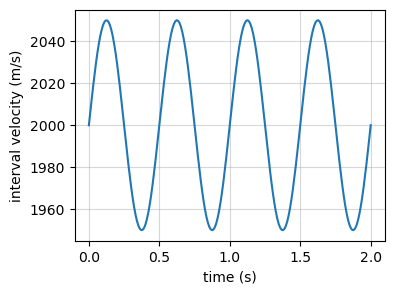

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3)) 

ax.plot(time, vint)
ax.set_xlabel("time (s)")
ax.set_ylabel("interval velocity (m/s)")
ax.grid(alpha=0.5)

# forward problem 

$$V_{rms}^2 (t) = \frac{1}{t}\int_0^{t_{max}} v_{int}^2(u) du$$

with 
- $v_{int} = v_0 + a \sin(2\pi f t)$
- $v_{int} = v_0 + a \sin(\omega t)$

The answer 

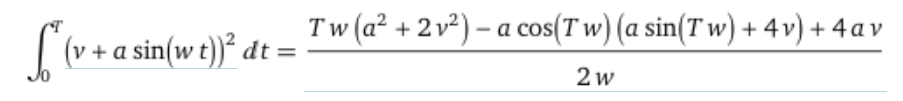

In [7]:
def rms_velocity_analytic(time, velocity0, amplitude, frequency): 
    omega = 2*np.pi*frequency

    inds_nonzero = time > 0 # in practice, you might want to pick a small number
    vrms2 = np.zeros_like(time) 
    # vrms2 = velocity0**2 * np.ones_like(time) 
    
    vrms2[inds_nonzero] = 1/time[inds_nonzero] * (
        (
            time[inds_nonzero] * omega * (amplitude**2 + 2 * velocity0**2)
            - amplitude * np.cos(time[inds_nonzero] * omega) * (amplitude * np.sin(time[inds_nonzero] * omega) + 4 * velocity0)
            + 4 * amplitude * velocity0
        ) / (2 * omega)
    )
    
    vrms = np.sqrt(vrms2)
    vrms[~inds_nonzero] = velocity0
    return vrms

Text(0, 0.5, 'RMS velocity (m/s)')

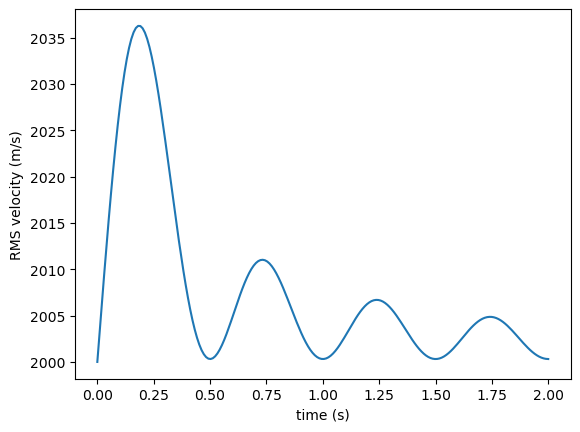

In [9]:
fig, ax = plt.subplots(1, 1) 

rms_velocity = rms_velocity_analytic(time, v0, a, f)

ax.plot(time, rms_velocity)
ax.set_xlabel("time (s)")
ax.set_ylabel("RMS velocity (m/s)")

# estimate vint from vrms2

$$v_{int} = V_{RMS} \left(1 + \frac{2 t V'_{RMS}}{V_{RMS}}\right)^{1/2}$$

Here we use a forward difference 

$V'_{i} \simeq (V_i - V_{i-1}) / dt_{i}$

In [32]:
vrms = rms_velocity_analytic(time, v0, a, f)

In [33]:
def compute_vint_from_vrms(time, vrms):
    dt = np.diff(time)
    dvdt_approx = np.diff(vrms) / dt
    dvdt_approx = np.r_[0, dvdt_approx]  # forward difference
    vint_rec = vrms * np.sqrt(
        1 + (2 * time * dvdt_approx)/vrms
    )
    return vint_rec 

In [34]:
vint_rec = compute_vint_from_vrms(time, vrms)

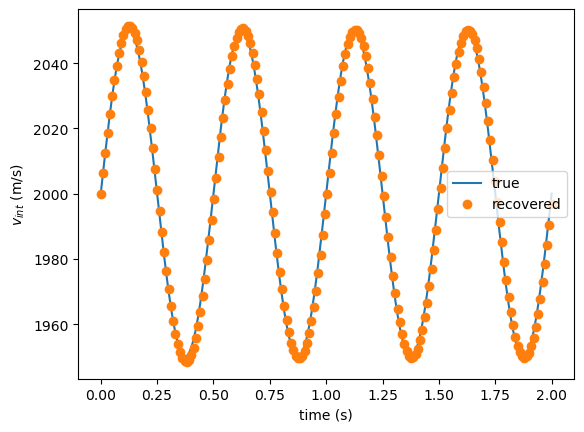

In [35]:
fig, ax = plt.subplots(1,1)

ax.plot(time, vint, label="true")
ax.plot(time, vint_rec, "o", label="recovered")
ax.set_ylabel("$v_{int}$ (m/s)")
ax.set_xlabel("time (s)")
ax.legend()

# Inverting with a finite number of accurate data

In [36]:
# tmp = np.arange(1, 10)
# tmp

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [40]:
# tmp[1::4]

array([2, 6])

In [117]:
decimate = 8
std = 2

t_obs = time[::decimate]
noise_vector = std * np.random.randn(len(t_obs))
vrms_obs = vrms[::decimate] + noise_vector

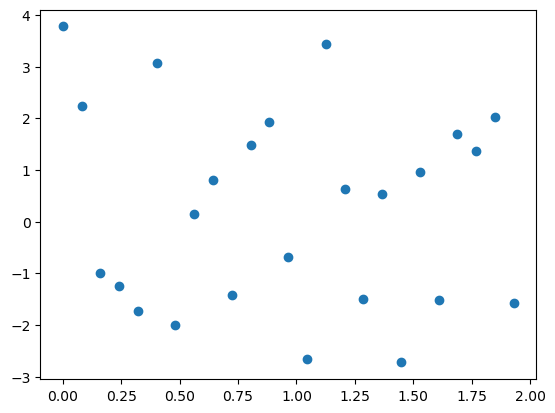

In [118]:
plt.plot(t_obs, noise_vector, "o")

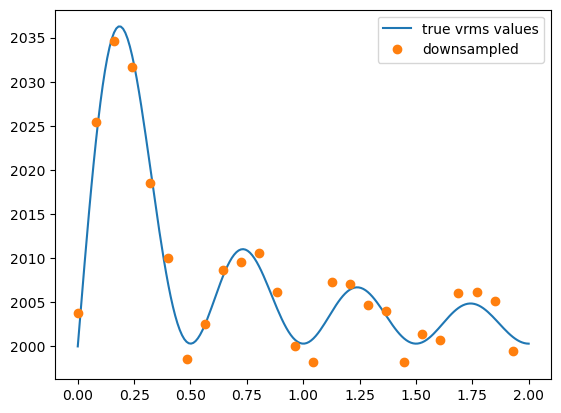

In [119]:
fig, ax = plt.subplots(1, 1)

ax.plot(time, vrms, label="true vrms values")
ax.plot(t_obs, vrms_obs, "o", label="downsampled")
ax.legend()

In [120]:
# interp1d?

In [121]:
linear_interpolation = interp1d(t_obs, vrms_obs, kind="linear", fill_value="extrapolate")
vrms_linear = linear_interpolation(time)

In [122]:
spline_interpolation = interp1d(t_obs, vrms_obs, kind="cubic", fill_value="extrapolate")
vrms_spline = spline_interpolation(time)

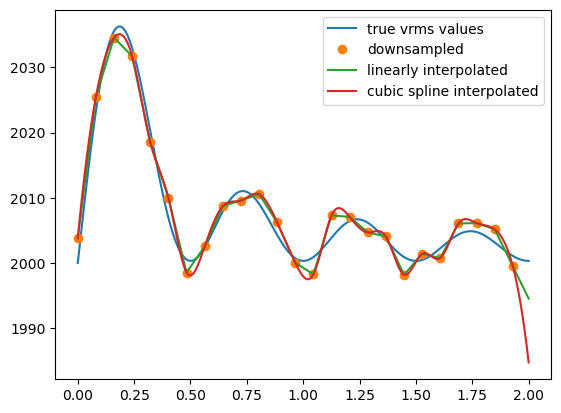

In [123]:
fig, ax = plt.subplots(1, 1)

ax.plot(time, vrms, label="true vrms values")
ax.plot(t_obs, vrms_obs, "o", label="downsampled")
ax.plot(time, vrms_linear, label="linearly interpolated")
ax.plot(time, vrms_spline, label="cubic spline interpolated")
ax.legend()

In [124]:
vint_linear_rec = compute_vint_from_vrms(time, vrms_linear)
vint_spline_rec = compute_vint_from_vrms(time, vrms_spline)

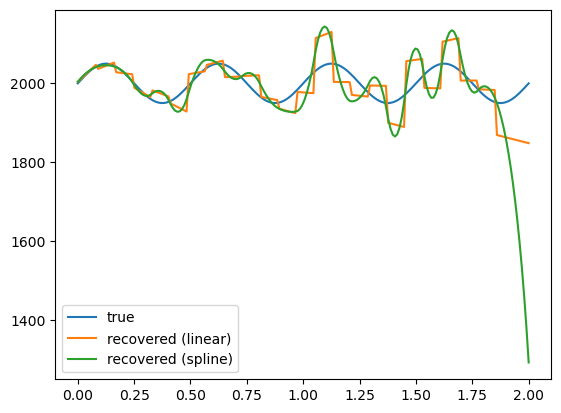

In [125]:
fig, ax = plt.subplots(1, 1)

ax.plot(time, vint, label="true")
ax.plot(time, vint_linear_rec, label="recovered (linear)")
ax.plot(time, vint_spline_rec, label="recovered (spline)")
ax.legend()

In [126]:
# simple example where we look at differentiation and integration

In [129]:
model_parameters = np.sin(2*np.pi*time)

In [131]:
import scipy.integrate as spi

def function(x):
    return np.sin(2*np.pi*x)  # Example function to integrate

# Define integration limits
a, b = 0, np.max(time)  # Integrate from 0 to T

# Perform integration using quad (adaptive quadrature method)
result, error = spi.quad(function, a, b)